### Student Information:
- Name: Yilun Wang
- BU email: yilun830@bu.edu
- Collaborators:Yipeng Guo / ypguo@bu.edu

# Minor Assignment 2: Audio data augmentation

## Set up - DO NOT EDIT THIS SECTION

In [ ]:
!pip install tensorflow_io
!pip install spec-augment
#!pip install audiomentations

     |████████████████████████████████| 23.4 MB 1.1 MB/s 
     |████████████████████████████████| 462 kB 13.4 MB/s 


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from spec_augment import SpecAugment
#from audiomentations import Compose, FrequencyMask

In [ ]:
dataset_links = {'train_data': 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                 'test_data': 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'}

In [ ]:
for key in dataset_links:
    tf.keras.utils.get_file(key+'.tar.gz',
                            dataset_links[key],
                            cache_dir='./',
                            cache_subdir='datasets/'+key,
                            extract=True)

112574464/112563277 [==============================] - 1s 0us/step


In [ ]:
train_data_paths = []
for folder, labels, samples in os.walk('./datasets/train_data/'):
    for sample in samples:
        if sample[-3:] == 'wav':
            train_data_paths.append([folder+'/'+sample, folder[22:]])

df = pd.DataFrame(train_data_paths, columns=['paths', 'labels'])
df = df.drop(df[df['labels'] =='_background_noise_'].index)
categories = df['labels'].unique()
digits_dict = {'zero':0, 'one':1, 'two':2, 
               'three':3, 'four':4, 'five':5,
               'six':6, 'seven':7, 'eight':8,
               'nine':9}
digits_index = []
for digit in digits_dict.keys():
    digits_index = digits_index + list(df[df['labels']==digit].index)
df = df.loc[digits_index]
df = df.sample(frac=1)
df.reset_index(inplace=True)

In [ ]:
# Audio import function with padding
def load_audio(filepath):
    """Takes the path of a wav audio file as input and creates
    a numpy array of shape (16000) as output. The input file
    needs to sample rate=16000. The expected duration is 1s,
    shorter samples are padded at the end while longer samples
    are cropped at 1s."""
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    audio = audio.to_tensor().numpy().reshape((-1)) / 32767.0
    audio = audio.astype(dtype="float32")
    len = audio.shape[0]
    # Padding
    if len == 16000:
        return audio
    elif len < 16000:
        return np.concatenate([audio, 
                               np.zeros(shape=(16000-len),
                                        dtype="float32")], 
                              axis=0)
    else:
        return audio[0:16000]


# The dataset class used to feed data to our model during training and evaluation.
class audio_gen(keras.utils.Sequence):
    def __init__(self, file_paths, labels,
                 batch_size=128, shape=(16000,1),
                 shuffle_on_epoch_end=True):
        # Initialization
        super().__init__()
        self.shape = shape
        self.batch_size = batch_size
        self.labels = labels
        self.paths = file_paths
        self.n_channels = shape[-1]
        self.n_classes = max(labels)+1
        self.shuffle = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[self.batch_size * idx: 
                                 self.batch_size * (idx+1)]
        batch_labels = self.labels[self.batch_size * idx:
                                   self.batch_size * (idx+1)]
        batch_samples = np.zeros(shape=(0, self.shape[0]), 
                                 dtype='float32')
        for path in batch_paths:
            batch_samples = np.concatenate([batch_samples, [load_audio(path)]], 
                                           axis=0)
        return batch_samples, np.array(batch_labels, dtype='int')

    def on_epoch_end(self):
        # suffle the dataset after each epoch
        if self.shuffle:
            self.paths, self.labels = shuffle(self.paths, self.labels)

In [ ]:
train_paths = np.array(df['paths'])[:3000]
train_labels = np.array([digits_dict[x] for x in df['labels']])[0:3000]

valid_paths = np.array(df['paths'])[3000:4000]
valid_labels = np.array([digits_dict[x] for x in df['labels']])[3000:4000]

test_paths = np.array(df['paths'])[4000:10000]
test_labels = np.array([digits_dict[x] for x in df['labels']])[4000:10000]

In [ ]:
train_gen = audio_gen(train_paths, train_labels)
valid_gen = audio_gen(valid_paths, valid_labels)
test_gen = audio_gen(test_paths, test_labels)

In [ ]:
def get_spectrogram(audio_tensor):
    return tfio.audio.spectrogram(audio_tensor,
                                  nfft=512,
                                  window=256,
                                  stride=128)

def mel_spectrogram(audio_tensor):
    return tfio.audio.melscale(get_spectrogram(audio_tensor),
                               rate=16000,
                               mels=128,
                               fmin=0,
                               fmax=8000)


def dbscale_spectrogram(audio_tensor):
    return tfio.audio.dbscale(mel_spectrogram(audio_tensor),
                              top_db=80)/60.0

In [ ]:
inputs = keras.Input(shape=(16000,))
x = layers.Lambda(lambda waveform: dbscale_spectrogram(waveform))(inputs)
x = layers.Reshape((125, 128, 1))(x)
x = layers.Conv2D(64, 8, 2, activation='relu')(x)
x = layers.MaxPooling2D(4)(x)
x = layers.Conv2D(128, 8, 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs = inputs, outputs = x)

#model.summary()

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

callback = keras.callbacks.ModelCheckpoint("/content/mA2_model.h5",
                                           monitor='val_loss',
                                           save_weights_only=True,
                                           save_best_only=True)

In [ ]:
history = model.fit(train_gen, validation_data=valid_gen,
                   epochs=2, callbacks=[callback])

Epoch 1/2
23/23 [==============================] - 17s 217ms/step - loss: 1.9892 - accuracy: 0.2959 - val_loss: 2.2896 - val_accuracy: 0.1473
Epoch 2/2
23/23 [==============================] - 5s 217ms/step - loss: 1.5683 - accuracy: 0.4847 - val_loss: 2.1757 - val_accuracy: 0.2757


In [ ]:
model.load_weights('/content/mA2_model.h5')

In [ ]:
#!wget https://github.com/ChasteloveCNN/ba765-session02/blob/main/mA2_model.h5

In [ ]:
#!chmod +rwx mA2_model.h5

In [ ]:
#model.load_weights('/')

In [ ]:
model.evaluate(test_gen)

46/46 [==============================] - 7s 150ms/step - loss: 2.1687 - accuracy: 0.2812


[2.168703079223633, 0.28125]

## Augmentation

The premise of data augmentation is to generate new data that could very well appear in our dataset. Perhaps the most straightforward type of augmentation is to recreate variations in the data collection process such as changing the environment (background noise) or the recording device (different microphone).

One particular difference between microphones is their sensitivity to different frequencies. In this assignment, you will modify the Lambda layer of the provided model to implement data augmentation by way of random "frequency masking".

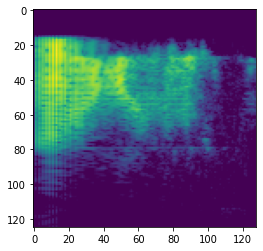

In [ ]:
waveform_sample = load_audio(df['paths'][30001])
spectrogram_sample = dbscale_spectrogram(waveform_sample)
plt.figure()
plt.imshow(spectrogram_sample.numpy())

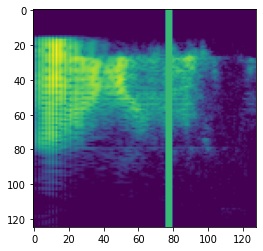

In [ ]:
freq_mask = tfio.audio.freq_mask(spectrogram_sample, 10)

plt.figure()
plt.imshow(freq_mask)

## Edit the cells below

Modify the model by adding an augmentation layer. Note that using a Lambda layer with tfio.audio.freq_mask will generate an error that I could not resolve. It'd be wonderful if you could resolve the error but I suggest using a custom augmentation layer using [spec-augment](https://pypi.org/project/spec-augment/)

In [ ]:
# Note: If you are using a custom layer you should modify the call function
# to make sure data is only augmented during training.
class CustomLambda(keras.layers.Layer):
    def __init__(self, param, **kwargs):
        super(CustomLambda, self).__init__(**kwargs)
        self.param = param

    def call(self, inputs, training=None):
        if training:
            # If you want to see the error that I couldn't resolve try using 
            # the layer as is.
            return tfio.audio.freq_mask(inputs, self.param)
        else:
            return inputs

In [ ]:
inputs = keras.Input(shape=(16000,))
x = layers.Lambda(lambda waveform: dbscale_spectrogram(waveform))(inputs)
x = layers.Reshape((125, 128, 1))(x)
# 
# x = augmentation layer
x = SpecAugment(freq_mask_param = 5, time_mask_param = 10,
                n_freq_mask = 10, n_time_mask = 0,
                mask_value = 0.0)(x)
# 
x = layers.Conv2D(64, 8, 2, activation='relu')(x)
x = layers.MaxPooling2D(4)(x)
x = layers.Conv2D(128, 8, 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
y = layers.Dense(10, activation='softmax')(x)

model_augmented = keras.Model(inputs = inputs, outputs = y)

model_augmented.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16000)]           0         
                                                                 
 lambda_1 (Lambda)           (None, 125, 128)          0         
                                                                 
 reshape_1 (Reshape)         (None, 125, 128, 1)       0         
                                                                 
 SpecAugment (SpecAugment)   (None, 125, 128, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 61, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 15, 64)       0         
 2D)                                                             
                                                           

In [ ]:
model_augmented.compile(optimizer="adam",
                        loss="sparse_categorical_crossentropy",
                        metrics=['accuracy'])

callback = keras.callbacks.ModelCheckpoint("/content/mA2_model_augmented.h5",
                                           monitor='val_loss',
                                           save_weights_only=True,
                                           save_best_only=True)

In [ ]:
history = model_augmented.fit(train_gen, validation_data=valid_gen,
                              epochs=100, callbacks=[callback])

Epoch 1/100
23/23 [==============================] - 17s 662ms/step - loss: 2.1413 - accuracy: 0.2361 - val_loss: 2.2767 - val_accuracy: 0.0904
Epoch 2/100
23/23 [==============================] - 15s 628ms/step - loss: 1.7531 - accuracy: 0.4046 - val_loss: 2.1901 - val_accuracy: 0.1585
Epoch 3/100
23/23 [==============================] - 15s 633ms/step - loss: 1.5344 - accuracy: 0.4898 - val_loss: 2.1387 - val_accuracy: 0.2076
Epoch 4/100
23/23 [==============================] - 15s 633ms/step - loss: 1.3911 - accuracy: 0.5554 - val_loss: 2.0492 - val_accuracy: 0.4286
Epoch 5/100
23/23 [==============================] - 15s 628ms/step - loss: 1.3069 - accuracy: 0.5853 - val_loss: 1.9807 - val_accuracy: 0.5357
Epoch 6/100
23/23 [==============================] - 15s 632ms/step - loss: 1.2315 - accuracy: 0.6199 - val_loss: 1.9270 - val_accuracy: 0.4107
Epoch 7/100
23/23 [==============================] - 15s 631ms/step - loss: 1.1674 - accuracy: 0.6471 - val_loss: 1.7912 - val_accuracy:

In [ ]:
model_augmented.load_weights('/content/mA2_model_augmented.h5')

In [ ]:
model_augmented.evaluate(test_gen)

46/46 [==============================] - 6s 138ms/step - loss: 0.4242 - accuracy: 0.8753


[0.42419907450675964, 0.875339686870575]